# SVD for Katherine Tindall aquifer

This is a description of the process used to create an SVD map of Tindal/Katherine WAP area.  

In [1]:
%matplotlib tk
import pystac_client, pickle, pyperclip, fiona
import odc.stac
import dask.distributed
import dask.array
import numpy as np
import geopandas as gpd
from IPython.display import JSON
import matplotlib.pyplot as plt
import rasterio as rio
import xarray as xr

## study area
The area is defined from a GDB polygon:

In [2]:
%ll -hd *.gdb

UsageError: Line magic function `%ll` not found.


In [3]:
fiona.listlayers("NT_Water_Mgt.gdb")

['NT_DISTRICTS',
 'NT_MGT_ZONES',
 'NT_PLAN_AREAS',
 'T_2_DirtyAreas',
 'T_2_PointErrors',
 'T_2_LineErrors',
 'T_2_PolyErrors']

<Figure size 640x480 with 0 Axes>

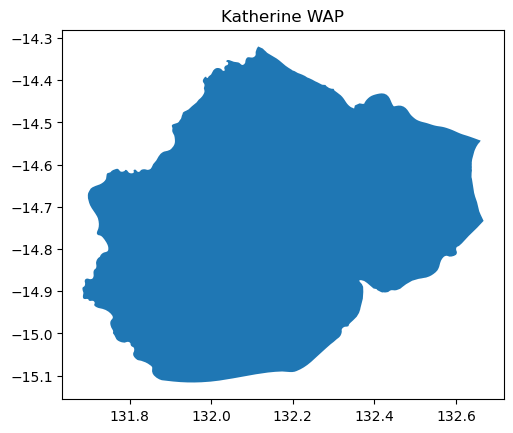

In [4]:
# layer 2 is NT_PLAN_AREAS
waps = gpd.read_file("NT_Water_Mgt.gdb", layer='NT_PLAN_AREAS')
#rivers = gpd.read_file("basemap.gpkg", layer='waterways')

%matplotlib inline
plt.figure()
waps[waps['PLAN_NAME'].str.contains("Katherine")].plot()
#rivers.plot()
plt.title("Katherine WAP")
plt.show()

In [5]:
bbox = waps[waps['PLAN_NAME'].str.contains("Katherine")].geometry.total_bounds
bbox

array([131.68443906, -15.11638809, 132.66751253, -14.32006288])

## Starting a dask server to get the Sentinal data

The raster data are collected from DEA, ran from a DASK cluster.

In [6]:
client = dask.distributed.Client(memory_limit='5GiB')
odc.stac.configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, client=client)
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 20,Total memory: 25.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56355,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 25.00 GiB
Comm: tcp://127.0.0.1:56407,Total threads: 4
Dashboard: http://127.0.0.1:56408/status,Memory: 5.00 GiB
Nanny: tcp://127.0.0.1:56358,


the client talks to the DEA server

In [7]:
catalog = pystac_client.Client.open('https://explorer.sandbox.dea.ga.gov.au/stac')

The bounding box should be collected directly from the geometry above, but for now it's just manually entered from QGIS.  

Here we request the date range from 2015 to present (the dates that S2 has been operational), and limit the search to complete images with 90% or more of the image visible.

## defining the search query

In [8]:
bbox=[131.6245, -15.1533, 132.7641, -14.3210] #mannually retrived from QGIS interface: Alice Springs more or less
#-15.1533,131.6245
#-14.3210,132.7641
start_date = "2015-12-01"
end_date = "2023-12-01"

#collections = ["ga_ls8c_ard_3"] #landsat 8 for now
collections = ['ga_s2am_ard_3' , 
    'ga_s2bm_ard_3']

quarg = {"query":
           {"properties.eo:cloud_cover": {
               "lte": 3
           },
            "properties.fmask:clear": {
                "gt": 90
            }
           }
        }


In [9]:
query = catalog.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{end_date}",
    **quarg
)

items=list(query.item_collection())
print(f"Found: {len(items):d} datasets")


Found: 42 datasets


The results are stored in JSON format, and then to a gdf to verify.  Thne next step may take 10 minutes or longer.

In [10]:
%time stac_json = query.get_all_items_as_dict()
%time stac_json = query.item_collection_as_dict()

c:\Users\mathe\anaconda3\lib\site-packages\pystac_client\item_search.py:865: FutureWarning: get_all_items_as_dict() is deprecated, use item_collection_as_dict() instead.
  warnings.warn(


CPU times: total: 1.06 s
Wall time: 45 s
CPU times: total: 0 ns
Wall time: 0 ns


In [11]:
JSON(stac_json)

<IPython.core.display.JSON object>

In [12]:
gdf = gpd.GeoDataFrame.from_features(stac_json)
gdf.columns

Index(['geometry', 'title', 'gsd', 'created', 'gqa:abs_x', 'gqa:abs_y',
       'gqa:cep90', 'proj:epsg', 'fmask:snow', 'gqa:abs_xy', 'gqa:mean_x',
       'gqa:mean_y', 'proj:shape', 'platform', 'fmask:clear', 'fmask:cloud',
       'fmask:water', 'gqa:mean_xy', 'gqa:stddev_x', 'gqa:stddev_y',
       'odc:producer', 'instruments', 'gqa:stddev_xy', 'eo:cloud_cover',
       'view:sun_azimuth', 'proj:transform', 'odc:file_format',
       'odc:region_code', 'sat:orbit_state', 'constellation',
       'view:sun_elevation', 's2cloudless:clear', 's2cloudless:cloud',
       'fmask:cloud_shadow', 'odc:product_family', 'sat:relative_orbit',
       'odc:dataset_version', 'dea:dataset_maturity', 'dea:product_maturity',
       'gqa:iterative_mean_x', 'gqa:iterative_mean_y', 'gqa:iterative_mean_xy',
       'sentinel:datastrip_id', 'sentinel:product_name',
       'gqa:iterative_stddev_x', 'gqa:iterative_stddev_y',
       'gqa:iterative_stddev_xy', 'gqa:abs_iterative_mean_x',
       'gqa:abs_iterative_me

In [13]:
gdf

,geometry,title,gsd,created,gqa:abs_x,gqa:abs_y,gqa:cep90,proj:epsg,fmask:snow,gqa:abs_xy,...,gqa:iterative_stddev_x,gqa:iterative_stddev_y,gqa:iterative_stddev_xy,gqa:abs_iterative_mean_x,gqa:abs_iterative_mean_y,gqa:abs_iterative_mean_xy,sentinel:sentinel_tile_id,sentinel:datatake_start_datetime,cubedash:region_code,datetime
0,"POLYGON ((133.23355 -14.67174, 133.23354 -14.6...",ga_s2am_ard_3-2-1_53LKD_2016-03-28_final,10.0,2023-01-05T13:21:19.942042Z,0.13,0.18,0.29,32753,0.238081,0.22,...,0.09,0.16,0.18,0.08,0.13,0.16,S2A_OPER_MSI_L1C_TL_SGS__20160328T081025_A0039...,2016-03-28T08:10:25Z,53LKD,2016-03-28T01:27:16.463000Z
1,"POLYGON ((132.22804 -13.55306, 133.24208 -13.5...",ga_s2am_ard_3-2-1_53LKE_2016-04-27_final,10.0,2022-11-02T14:26:02.924934Z,0.30,0.33,0.62,32753,0.004758,0.44,...,0.17,0.25,0.31,0.25,0.25,0.35,S2A_OPER_MSI_L1C_TL_SGS__20160427T062256_A0044...,2016-04-27T06:22:56Z,53LKE,2016-04-27T01:27:17.458000Z
2,"POLYGON ((130.86370 -15.45718, 130.86259 -15.3...",ga_s2am_ard_3-2-1_52LGJ_2016-08-05_final,10.0,2022-11-01T19:07:21.963445Z,0.34,0.27,0.54,32752,0.257469,0.44,...,0.09,0.08,0.12,0.33,0.26,0.42,S2A_OPER_MSI_L1C_TL_SGS__20160805T080852_A0058...,2016-08-05T08:08:52Z,52LGJ,2016-08-05T01:31:22.180000Z
3,"POLYGON ((131.04846 -14.55229, 131.04824 -14.5...",ga_s2am_ard_3-2-1_52LGK_2016-08-05_final,10.0,2022-11-01T19:03:27.175095Z,0.36,0.21,0.53,32752,0.265634,0.42,...,0.10,0.09,0.13,0.34,0.19,0.39,S2A_OPER_MSI_L1C_TL_SGS__20160805T080852_A0058...,2016-08-05T08:08:52Z,52LGK,2016-08-05T01:31:22.180000Z
4,"POLYGON ((131.06555 -14.55214, 131.06518 -14.5...",ga_s2am_ard_3-2-1_52LGK_2016-06-26_final,10.0,2022-12-25T04:20:27.747177Z,0.34,0.21,0.51,32752,0.227466,0.40,...,0.10,0.10,0.14,0.32,0.18,0.37,S2A_OPER_MSI_L1C_TL_SGS__20160626T080606_A0052...,2016-06-26T08:06:06Z,52LGK,2016-06-26T01:31:01.140000Z
5,"POLYGON ((130.86370 -15.45718, 130.86260 -15.3...",ga_s2am_ard_3-2-1_52LGJ_2016-06-06_final,10.0,2022-12-25T05:16:53.045995Z,0.32,0.54,0.80,32752,0.182404,0.63,...,0.10,0.13,0.16,0.32,0.54,0.63,S2A_OPER_MSI_L1C_TL_SGS__20160606T062050_A0049...,2016-06-06T06:20:50Z,52LGJ,2016-06-06T01:28:03.752000Z
6,"POLYGON ((131.78244 -14.45584, 132.79950 -14.4...",ga_s2am_ard_3-2-1_52LHJ_2016-06-06_final,10.0,2022-12-25T05:17:03.935707Z,0.21,0.29,0.48,32752,0.000992,0.36,...,0.11,0.18,0.21,0.19,0.25,0.31,S2A_OPER_MSI_L1C_TL_SGS__20160606T062050_A0049...,2016-06-06T06:20:50Z,52LHJ,2016-06-06T01:28:03.752000Z
7,"POLYGON ((132.22804 -13.55306, 133.24208 -13.5...",ga_s2am_ard_3-2-1_53LKE_2016-06-06_final,10.0,2022-12-25T05:24:39.569851Z,0.20,0.34,0.48,32753,0.000879,0.39,...,0.14,0.26,0.30,0.16,0.24,0.29,S2A_OPER_MSI_L1C_TL_SGS__20160606T062050_A0049...,2016-06-06T06:20:50Z,53LKE,2016-06-06T01:28:03.752000Z
8,"POLYGON ((131.77159 -13.55307, 132.78470 -13.5...",ga_s2am_ard_3-2-1_52LHK_2016-06-06_final,10.0,2022-12-25T05:23:12.177984Z,0.24,0.29,0.51,32752,0.000912,0.38,...,0.11,0.14,0.18,0.22,0.24,0.33,S2A_OPER_MSI_L1C_TL_SGS__20160606T062050_A0049...,2016-06-06T06:20:50Z,52LHK,2016-06-06T01:28:03.752000Z
9,"POLYGON ((132.21719 -14.45583, 133.23519 -14.4...",ga_s2am_ard_3-2-1_53LKD_2016-06-06_final,10.0,2022-12-25T05:24:03.478464Z,0.24,0.44,0.70,32753,0.002651,0.50,...,0.23,0.32,0.39,0.17,0.31,0.35,S2A_OPER_MSI_L1C_TL_SGS__20160606T062050_A0049...,2016-06-06T06:20:50Z,53LKD,2016-06-06T01:28:03.752000Z


<Axes: >

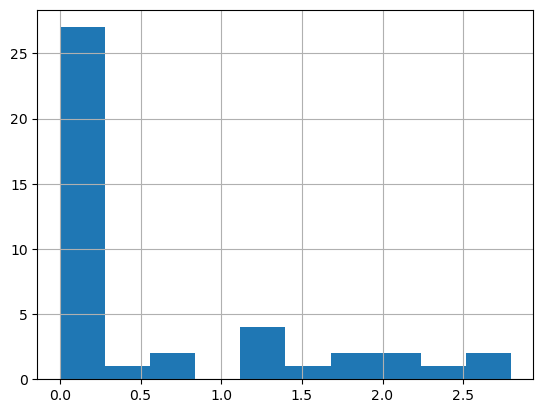

In [14]:
gdf['eo:cloud_cover'].hist()

Even though it's sentinal, it's collected at 30m resolution, as 10m was taking way too long under current conditions.

In [15]:
crs = "EPSG:28353"
resolution = 30

ds = odc.stac.load(
    items,
    bands=("nbart_red", "nbart_nir_1"),
    crs=crs,
    resolution=resolution,
    chunks={},
    groupby="solar_day",
    bbox=bbox
)

In [16]:
# odc-stac library downloads DEA datasets stored in AWS
# when external to AWS (like outside DEA sandbox), AWS signed requests must be disabled
import os
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

In [17]:
ds.keys()

KeysView(<xarray.Dataset>
Dimensions:      (y: 3124, x: 4133, time: 10)
Coordinates:
  * y            (y) float64 8.416e+06 8.416e+06 ... 8.322e+06 8.322e+06
  * x            (x) float64 1.358e+05 1.358e+05 ... 2.597e+05 2.598e+05
    spatial_ref  int32 28353
  * time         (time) datetime64[ns] 2016-03-28T01:27:16.463000 ... 2016-11...
Data variables:
    nbart_red    (time, y, x) float32 dask.array<chunksize=(1, 3124, 4133), meta=np.ndarray>
    nbart_nir_1  (time, y, x) float32 dask.array<chunksize=(1, 3124, 4133), meta=np.ndarray>)

### caluclating image completeness

Since this is not apparently an attribute of the search results, it's calculated here.  Warning, it can take a couple of hours to complete once dask is asked for values.

In [32]:
ds["frac"]= ds.nbart_red.count(dim=["x", "y"]) / (ds.nbart_red.size / len(ds.time))

In [33]:
%time mFrac = ds.frac.values

CPU times: total: 5.17 s
Wall time: 4min 44s


Find what constitutes a complete image, and subset the collection to those that exceed that threshold.

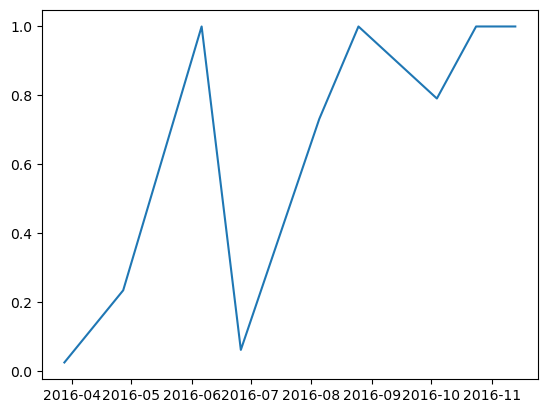

In [34]:
plt.plot(ds.time, mFrac)

In [35]:
len(mFrac[mFrac > .9])

5

And pickle the results, since it took so long to get them.

In [39]:
with open(f"ndvi-mFrac-20231015-30m.pkl", 'wb') as of:
    pickle.dump(mFrac, of)

In [41]:
ds["NDVI"] = (ds.nbart_nir_1 - ds.nbart_red) / (ds.nbart_nir_1 + ds.nbart_red)
#ds["valid"] = ds.NDVI.count() / ds.NDVI.size()

In [42]:
ds

<xarray.Dataset>
Dimensions:      (y: 3124, x: 4133, time: 10)
Coordinates:
  * y            (y) float64 8.416e+06 8.416e+06 ... 8.322e+06 8.322e+06
  * x            (x) float64 1.358e+05 1.358e+05 ... 2.597e+05 2.598e+05
    spatial_ref  int32 28353
  * time         (time) datetime64[ns] 2016-03-28T01:27:16.463000 ... 2016-11...
Data variables:
    nbart_red    (time, y, x) float32 dask.array<chunksize=(1, 3124, 4133), meta=np.ndarray>
    nbart_nir_1  (time, y, x) float32 dask.array<chunksize=(1, 3124, 4133), meta=np.ndarray>
    frac         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    NDVI         (time, y, x) float32 dask.array<chunksize=(1, 3124, 4133), meta=np.ndarray>

In [43]:
%time dsr = np.nan_to_num(ds.NDVI[mFrac > .9])

Task exception was never retrieved
future: <Task finished name='Task-145964' coro=<Client._gather.<locals>.wait() done, defined at c:\Users\mathe\anaconda3\lib\site-packages\distributed\client.py:2002> exception=AllExit()>
Traceback (most recent call last):
  File "c:\Users\mathe\anaconda3\lib\asyncio\tasks.py", line 232, in __step
    result = coro.send(None)
  File "c:\Users\mathe\anaconda3\lib\site-packages\distributed\client.py", line 2011, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-145965' coro=<Client._gather.<locals>.wait() done, defined at c:\Users\mathe\anaconda3\lib\site-packages\distributed\client.py:2002> exception=AllExit()>
Traceback (most recent call last):
  File "c:\Users\mathe\anaconda3\lib\asyncio\tasks.py", line 232, in __step
    result = coro.send(None)
  File "c:\Users\mathe\anaconda3\lib\site-packages\distributed\client.py", line 2011, in wait
    raise AllExit()
distributed.client.

CPU times: total: 6.94 s
Wall time: 5min 31s


In [44]:
images = dsr

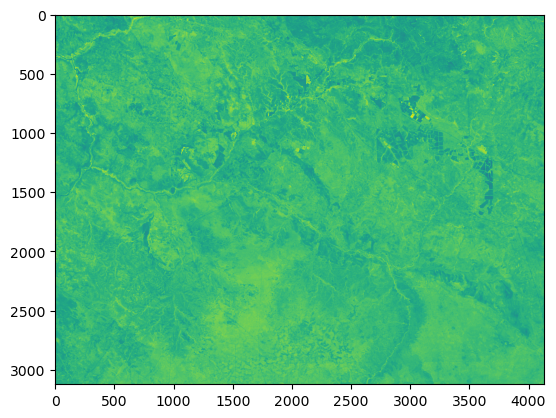

In [47]:
plt.imshow(dsr[0])

In [48]:
# write the results to pickles
with open(f"ndvi-s2-30m.pkl", 'wb') as of:
    pickle.dump(dsr, of)
with open(f"ndvi-s2-30m-dates.pkl", 'wb') as of:
    pickle.dump(ds.time[mFrac > .9], of)

In [49]:
dates = ds.time[mFrac > .9]

In [50]:
dates

<xarray.DataArray 'time' (time: 5)>
array(['2016-06-06T01:28:03.752000000', '2016-08-25T01:27:17.456000000',
       '2016-10-24T01:27:12.456000000', '2016-11-03T01:29:53.199000000',
       '2016-11-13T01:31:05.357000000'], dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 28353
  * time         (time) datetime64[ns] 2016-06-06T01:28:03.752000 ... 2016-11...

## Computing the SVD

In [51]:
M = dsr.reshape(dsr.shape[0], -1)

In [52]:
# the alternative, if dsr isn't in memory
M = images.reshape(images.shape[0], -1)

In [53]:
%time U, s, Vt = np.linalg.svd(M - M.mean(), full_matrices=False)

CPU times: total: 10.7 s
Wall time: 3.73 s


In [54]:
s2 = s**2
comp=50
print(f"first {comp} components:")
print("\n".join([f"{i+1:>3}: {j/s2.sum():>.4f} | {s2[:i+1].sum()/s2.sum():>.4f}" 
                 for i,j in enumerate(s2[:comp])]))

first 50 components:
  1: 0.6399 | 0.6399
  2: 0.2545 | 0.8944
  3: 0.0634 | 0.9578
  4: 0.0341 | 0.9918
  5: 0.0082 | 1.0000


In [55]:
dsr[0].shape

(3124, 4133)

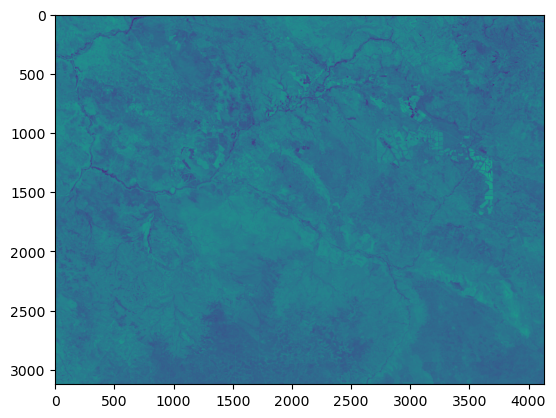

In [58]:
plt.imshow(Vt[0].reshape(dsr[0].shape))

## writing output to geotiffs

In [57]:
src_meta = {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0}

In [63]:
src_meta['width'] = len(ds.x)
src_meta['height'] = len(ds.y)
src_meta['crs'] = rio.CRS.from_epsg(ds.spatial_ref)
src_meta['transform'] = rio.Affine(resolution, 0.0, ds.x[0].values - resolution/2, 
                                   0.0, -resolution, ds.y[0].values + resolution/2)
src_meta['count'] = 4

In [64]:
src_meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': 0,
 'width': 4133,
 'height': 3124,
 'crs': CRS.from_epsg(28353),
 'transform': Affine(30.0, 0.0, 135780.0,
        0.0, -30.0, 8415630.0),
 'count': 4}

In [66]:
eigs = Vt.reshape(dsr.shape)
with rio.open("eigenlayers-s2-30.tif", 'w', **src_meta) as dst:
    for i in range(4):
        tsImage = eigs[i]
        dst.write(tsImage, i+1)
with open(f"ndvi-s2-30m-eigs.pkl", 'wb') as of:
    pickle.dump(eigs, of)
         

In [67]:
%ls -lh *.pkl

 Volume in drive C is Windows-SSD
 Volume Serial Number is 8680-F1B8

 Directory of c:\Users\mathe\DEPWS\katherine\basemap


 Directory of c:\Users\mathe\DEPWS\katherine\basemap

16/10/2023  02:16 PM     4,338,261,481 ndvi-l8-30m.pkl
16/10/2023  02:16 PM             4,082 ndvi-l8-30m-dates.pkl
15/10/2023  07:56 PM             1,350 ndvi-mFrac-20231015.pkl
17/01/2024  12:46 PM               227 ndvi-mFrac-20231015-30m.pkl
16/10/2023  02:31 PM     4,338,261,481 ndvi-s2-10m-eigs.pkl
17/01/2024  12:55 PM       258,230,005 ndvi-s2-30m.pkl
17/01/2024  12:55 PM             2,812 ndvi-s2-30m-dates.pkl
17/01/2024  01:05 PM       258,230,005 ndvi-s2-30m-eigs.pkl
               8 File(s)  9,192,991,443 bytes
               0 Dir(s)  682,665,033,728 bytes free


# Opening saved data 

In [68]:
#load all the visuals if needed
#with open("ndvi-s2-30m-eigs.pkl", 'rb') as inf:
#    eigs = pickle.load(inf)
with open("ndvi-s2-30m-dates.pkl", 'rb') as inf:
    dates = pickle.load(inf)
with open("ndvi-s2-30m.pkl", 'rb') as inf:
    images = pickle.load(inf)
with rio.open("eigenlayers-s2-30.tif") as src:
    sTrans = src.transform
    eigs = src.read()

In [69]:
eigs.shape

(4, 3124, 4133)

## Plotting the TS

In [70]:
# get a color map of the three eigenvalues scaled to their eigenlayers
# assign which eigenlayers go to each band
cmp = {'red': 0, 'green': 1, 'blue': 2}
flip = (1,-1, 1)
eigr = lambda e: eigs[cmp[e]]
    
# stretch the range of the color band to +- 2 stddev
stdRange = lambda e: {'min': eigr(e).mean() - eigr(e).std() * 2 * flip[cmp[e]],
                      'max': eigr(e).mean() + eigr(e).std() * 2 * flip[cmp[e]]}
# assign these ranges to a hash
ranges = {i: stdRange(i) for i in cmp.keys()}
    
sclr = lambda  cl: (eigr(cl)[mr, mc] - ranges[cl]['min']) / \
                   (ranges[cl]['max'] - ranges[cl]['min'])


def scmpfinder (mr, mc):
    # how to compute a particular eigenvalue as a fraction of its range

    # how to compute a particular eigenvalue as a fraction of its range
    #sclr = lambda  cl: (eigs[cmp[cl], mr, mc] - ranges[cl]['min']) / \
    #        (ranges[cl]['max'] - ranges[cl]['min'])
          
    # create RGB colour list of the three ranges
    scmp = [sclr(i) for i in cmp.keys()]
    #scmp =  [sclr('red'), sclr('green'), sclr('blue')]
    # and chop the bits that exceed [0:1]
    for i, v in enumerate(scmp):
        if v < 0.0: scmp[i] = 0.0
        if v > 1.0: scmp[i] = 1.0
        
    return scmp


UTM coords: [226381.0, 8369924.0]
matrix coords: (1523, 3020)


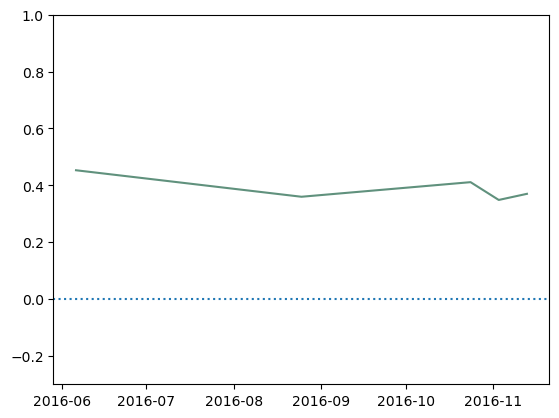

In [73]:
# get the dates from the series
#dates = [i.properties.date for i in gScenes]
# set the plot limit to a fixed range
plt.ylim(-.3,1)
# get the matrix diminsions from the saved tif file
#with rio.open("max_ndvi.tif") as src:
#sTrans = src_meta['transform']
#sTrans = src.transform

# get the coordinates I wish to plot (currently in UTM53N)
#coords = 280929.5,8361645.4
# this gets the coordinates from the clipboard from QGIS.  It comes
# as a string of two numbers separated by a comma, this turns it into 
# a pair of floating point numbers
coords = [float(s) for s in str(pyperclip.paste()).split(',')]
print(f'UTM coords: {coords}')
# translate these into row, col based on the raster tranform matrix
# rowcol = rio.transform.rowcol(sTrans,*coords)
rowcol = lambda r, c: rio.transform.rowcol(sTrans, r, c)
print(f'matrix coords: {rowcol(*coords)}')

mr, mc = rowcol(*coords)
# get the corresponding time series from the images matrix and plot it
#mages[:, mr, mc]
# get the colormap according to its eigenlayers, and plot
scmp = scmpfinder(mr, mc)
plt.plot(dates, np.ma.getdata(images[:, mr, mc]), color=scmp)

plt.axhline(0, linestyle=':')


In [ ]:
plt.clf()

In [ ]:
pyperclip.paste()

In [ ]:
eigs[0].shape

In [ ]:
images.shape

In [ ]:
pyperclip.paste()

In [ ]:
%ll -h *.pkl

In [ ]:
191346.6,8372684.3

In [ ]:
Vt.shape

## createing a reduced image set from main components

This step assumes that you have the `U`, `s`, and `Vt` eigenmatrices computed and available (from $U$, $S$, and $V^T$)

In [ ]:
sub = 15
im2 = U[:,:sub] @ np.diag(s[:sub]) @ Vt[:sub, :]
im2 = im2 + images.mean()
images2 = (im2.reshape(images.shape))

In [ ]:
# get the dates from the series
#dates = [i.properties.date for i in gScenes]
# set the plot limit to a fixed range
plt.ylim(-.3,1)
# get the matrix diminsions from the saved tif file
#with rio.open("max_ndvi.tif") as src:
#sTrans = src_meta['transform']
#sTrans = src.transform

# get the coordinates I wish to plot (currently in UTM53N)
#coords = 280929.5,8361645.4
# this gets the coordinates from the clipboard from QGIS.  It comes
# as a string of two numbers separated by a comma, this turns it into 
# a pair of floating point numbers
coords = [float(s) for s in str(pyperclip.paste()).split(',')]
print(coords)
# translate these into row, col based on the raster tranform matrix
# rowcol = rio.transform.rowcol(sTrans,*coords)
rowcol = lambda r, c: rio.transform.rowcol(sTrans, r, c)
print(rowcol(*coords))

mr, mc = rowcol(*coords)
# get the corresponding time series from the images matrix and plot it
#mages[:, mr, mc]
# get the colormap according to its eigenlayers, and plot
scmp = scmpfinder(mr, mc)
plt.plot(dates, np.ma.getdata(images[:, mr, mc]), color=scmp)
plt.plot(dates, np.ma.getdata(images2[:, mr, mc]), color=scmp, alpha=.5)

plt.axhline(0, linestyle=':')


In [ ]:
plt.clf()

In [ ]:
im2.mean()

In [ ]:
M.mean()

In [ ]:
images.mean()

# Classification of GDEs

I'm using **dzetsaka** as the seemingly more capale `SCP` was too glitchy.

I will add screenshots later but will write a verbal description as a placeholder:

I used the **dzetsaka** interface, and created a training layer called `training1.shp` in an `rfclass` directory.


While minimal, it defines 7 classes of cover:


In [ ]:
tr1 = gpd.read_file("rfclass/training1.shp")
print(tr1)
# effectively: select distinct id, class from tr1
tr1[["id", "class"]].drop_duplicates()

There are two classes of forest, a consistently high NDVI kind near the rivers, and a high but noticeably seasonal one that is further from rivers.  I will decide how to combine these following advice.

I ran the random forest classifier on the `eigenlayers-s2-30.tif` dataset, using the 6 top component layers as input.  The outputs were called `rf*`, and their corresponding confidence estimates were called `conf*`

In [ ]:
%ls -lh rfclass/*.tif

Each rfclass has 7 values:

In [ ]:
rft = rio.open("rfclass/rf1.tif").read(1)
cft = rio.open("rfclass/conf1.tif").read(1)

fig, axes = plt.subplots(2,2, tight_layout=True)

axes[0,0].hist(rft.flatten(), bins=range(10))
axes[0,1].imshow(rft, cmap="Set3")
axes[0,1].set_title("classes")
axes[1,0].hist(cft.flatten())
axes[1,1].imshow(cft, cmap="cool")
axes[1,1].set_title("confidence")

fig.suptitle("random forest classes", fontsize=18)


and the confidence values range between $[0,100]$, where 100 means absolutely confident and 0 means absolutely not confident in the classification.

## extracting the GDEs from the vegmaps

Classes 1 and 2 are riverine and forest, both likely candidates for GDEs.  Since the RF has been run5 times, each with slightly different results, I wish to have a measure of consistency of the results (how many times out of 5 was a forest a forest?).  I would also like to consider this in context of the confidence of the classification.

**tasks for accomplishing this**

1) Need to extract forest classes (using `reclassify`)
2) need to take average of 5 covers into final cover
3) apply collective confidence band to final as
* fractional value
* transperancy value

### developing the technique first...

The next few cells show my working this technique out on a single `rclass` pair

In [ ]:
# first try do an individual one manually:
rft = rio.open("rfclass/rf1.tif").read(1)
cft = rio.open("rfclass/conf1.tif").read(1)

rft[rft>2] = 0
rct = rft * cft / 100.0
#rft[rft<=2] = 1
#plt.imshow(rft,cmap="Set1")
plt.hist(rct.flatten(), bins=20)

In [ ]:
rftm = rio.open('rfclass/rf1.tif')

In [ ]:
rftm.meta

In [ ]:
src_meta = rftm.meta
src_meta['dtype'] = 'float32'
with rio.open("rfclass/rct2.tif", 'w', **src_meta) as dst:
    dst.write(rct, 1)

### now try it in a loop

First take all the classified landcover maps and change it to forest and GDE = 1, everything else is 0.

In [ ]:
for i in range(5):
    rft = rio.open(f"rfclass/rf{i+1}.tif").read(1)
    cft = rio.open(f"rfclass/conf{i+1}.tif").read(1)

    rft[rft>2] = 0
    # next time I should add a statement to rft[rft==2] = 1
    rft[rft==2] = 1
    rct = rft * cft / 100.0
    if i == 0: rclass = rct / 5
    else: rclass += rct / 5
rclass[rclass > 1] = 1

In [ ]:
src_meta = rftm.meta
src_meta['dtype'] = 'int'
with rio.open("rfclass/rclass.tif", 'w', **src_meta) as dst:
    dst.write(rclass, 1)

This last bit is to update the classification layer, so that all pixels where the confidence of classification is less than 50% (`cft < 50`) is classified as 0.

In [ ]:
rft = rio.open(f"rfclass/rf{i+1}.tif").read(1)

In [ ]:
rft[cft < 50] = 0

In [ ]:
with rio.open("rfclass/all-classes.tif", 'w', **src_meta) as dst:
    dst.write(rft, 1)